🔍 Loaded local indicators sample:
      Bankf  Agrimach
Year                 
2000  13.53     93516
2001  12.39    100221
2002  15.14     93455
2003  19.25     97137
2004  20.10     97353 

🔍 Using WDI data file: WDI_excel_2023_07_25.zip
🔍 Sample of reshaped WDI indicators:
Indicator Code   Agriland  RuralGrowth  Agriwork
Year                                            
2000            7662000.0    17.977308  22.21172
2001            7583000.0     5.665619  21.71543
2002            7547000.0     3.602892  21.73323
2003            7503700.0     8.796259  21.72203
2004            7493000.0     6.951450  21.34046 

🔍 Merged and imputed dataset sample:
      Bankf  Agrimach   Agriland  RuralGrowth  Agriwork
Year                                                   
2000  13.53     93516  7662000.0    17.977308  22.21172
2001  12.39    100221  7583000.0     5.665619  21.71543
2002  15.14     93455  7547000.0     3.602892  21.73323
2003  19.25     97137  7503700.0     8.796259  21.72203
2004  2

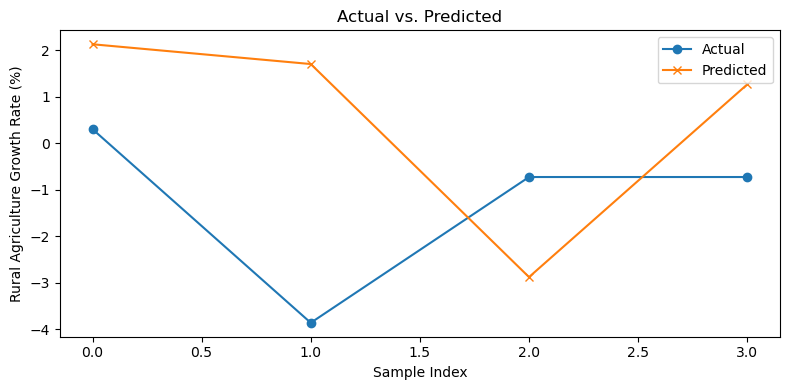

5-Year Forecast: ['1.26%', '2.93%', '1.70%', '5.97%', '5.98%']


D:\Anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [27]:

import os
import random
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Set random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

# Load local cleaned data (Bankf and Agrimach)
local_csv = 'Statistical Yearbook_cleaned_data.csv'
wdi_zip = 'WDI_excel_2023_07_25.zip'

# Read local agricultural financing and mechanization data
df_local = pd.read_csv(local_csv, dtype={'Year': int})
df_local = df_local.set_index('Year')[['Bankf', 'Agrimach']]

# Read WDI Excel from ZIP
year_cols = [str(y) for y in range(2000, 2023)]
usecols = ['Country Code', 'Indicator Code'] + year_cols
with zipfile.ZipFile(wdi_zip, 'r') as z:
    xlsx_name = next(name for name in z.namelist() if name.endswith('.xlsx'))
    df_wdi = pd.read_excel(z.open(xlsx_name), sheet_name='Data', usecols=usecols)

# Select relevant indicators for Algeria
wdi_codes = {
    'Agriland': 'AG.LND.ARBL.HA',
    'Agriwork': 'SL.AGR.EMPL.ZS',
    'RuralGrowth': 'NY.ADJ.NNTY.KD.ZG'
}
df_sel = df_wdi[
    (df_wdi['Country Code'] == 'DZA') &
    (df_wdi['Indicator Code'].isin(wdi_codes.values()))
].copy()

# Reshape WDI data to wide format
df_long = df_sel.melt(id_vars=['Indicator Code'], value_vars=year_cols,
                      var_name='Year', value_name='Value')
df_wide = df_long.pivot(index='Year', columns='Indicator Code', values='Value')
df_wide.index = df_wide.index.astype(int)
df_wdi_proc = df_wide.rename(columns={v: k for k, v in wdi_codes.items()})

# Merge local and WDI data on year
df = df_local.join(df_wdi_proc, how='outer').sort_index()

# Fill missing values with appropriate methods
df['Agriland'] = df['Agriland'].ffill()
years = df.index.values
mask = df['Agriwork'].notna()
slope, intercept = np.polyfit(years[mask], df.loc[mask, 'Agriwork'], 1)
df.loc[~mask, 'Agriwork'] = slope * df.loc[~mask].index + intercept
df['RuralGrowth'] = df['RuralGrowth'].fillna(df.loc[2018:2020, 'RuralGrowth'].mean())

# Scale input features and target
df = df.dropna()
features = ['Bankf', 'Agrimach', 'Agriland', 'Agriwork']
X_scaler = MinMaxScaler()
X_all = X_scaler.fit_transform(df[features])
y_scaler = MinMaxScaler()
y_all = y_scaler.fit_transform(df[['RuralGrowth']]).ravel()

# Build LSTM sequences
def create_lstm_sequences(X, y, look_back):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        Xs.append(X[i : i + look_back])
        ys.append(y[i + look_back])
    return np.array(Xs), np.array(ys)

look_back = 5
phase1_years = list(range(2000, 2006))
phase2_years = list(range(2006, 2021))
mask1 = df.index.isin(phase1_years)
mask2 = df.index.isin(phase2_years)
X1_full, y1_full = create_lstm_sequences(X_all[mask1], y_all[mask1], look_back)
X2_full, y2_full = create_lstm_sequences(X_all[mask2], y_all[mask2], look_back)

# Split into training and validation sets
def split_phase(X, y, ratio=0.8):
    n = int(len(X) * ratio)
    return X[:n], y[:n], X[n:], y[n:]

X1_tr, y1_tr, X1_val, y1_val = split_phase(X1_full, y1_full)
X2_tr, y2_tr, X2_val, y2_val = split_phase(X2_full, y2_full)

# Define and compile LSTM model
def build_lstm_model(units, lr, input_shape):
    model = Sequential([
        LSTM(units, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

# Hyperparameter tuning
units_list = [16, 32]
lrs = [1e-3, 1e-2]
batches = [16, 32]
epochs = 50
phase_best = {}
phase_rmse_records = {1: [], 2: []}

# Grid search over hyperparameters
for pid, (X_tr, y_tr, X_val, y_val) in enumerate(
    [(X1_tr, y1_tr, X1_val, y1_val), (X2_tr, y2_tr, X2_val, y2_val)], start=1):
    best = {'rmse': float('inf')}
    for u in units_list:
        for lr in lrs:
            for bs in batches:
                m = build_lstm_model(u, lr, input_shape=(look_back, len(features)))
                m.fit(X_tr, y_tr, epochs=epochs, batch_size=bs, verbose=0)
                y_hat = m.predict(X_val, verbose=0).ravel()
                rmse = np.sqrt(mean_squared_error(
                    y_scaler.inverse_transform(y_val.reshape(-1,1)).ravel(),
                    y_scaler.inverse_transform(y_hat.reshape(-1,1)).ravel()
                ))
                label = f"units={u}, lr={lr}, bs={bs}"
                phase_rmse_records[pid].append((label, rmse))
                if rmse < best['rmse']:
                    best.update({'units':u, 'lr':lr, 'bs':bs, 'rmse':rmse})
    phase_best[pid] = best

# Retrain best models on full data
final_models = {}
for pid, (Xf, yf) in enumerate([(X1_full, y1_full), (X2_full, y2_full)], start=1):
    cfg = phase_best[pid]
    m = build_lstm_model(cfg['units'], cfg['lr'], input_shape=(look_back, len(features)))
    m.fit(Xf, yf, epochs=epochs, batch_size=cfg['bs'], verbose=0)
    final_models[pid] = m

# Predict and reconstruct time series
years_fit = phase1_years[look_back:] + phase2_years[look_back:]
y_true_fit = np.concatenate([y1_full, y2_full])
y_pred_fit = np.concatenate([
    final_models[1].predict(X1_full).ravel(),
    final_models[2].predict(X2_full).ravel()
])
y_true_fit = y_scaler.inverse_transform(y_true_fit.reshape(-1,1)).ravel()
y_pred_fit = y_scaler.inverse_transform(y_pred_fit.reshape(-1,1)).ravel()

# 5-year forward forecast
last_seq = X2_full[-1].copy()
f_scaled = []
for _ in range(5):
    p = final_models[2].predict(last_seq[np.newaxis], verbose=0).ravel()[0]
    f_scaled.append(p)
    last_seq = np.vstack([last_seq[1:], [p]*last_seq.shape[1]])
forecast5 = y_scaler.inverse_transform(np.array(f_scaled).reshape(-1,1)).ravel()

# Visualization Section
# Distribution of input variables
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()
for i, var in enumerate(features):
    axs[i].hist(df[var].dropna(), bins=10, color='skyblue', edgecolor='black')
    axs[i].set_title(f'Distribution of {var}')
plt.suptitle("Figure 1: Distribution of Input Variables")
plt.tight_layout()
plt.show()

# Correlation matrix heatmap
plt.figure(figsize=(8, 6))
corr = df[features + ['RuralGrowth']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Figure 2: Correlation Matrix of Inputs and Rural Growth')
plt.tight_layout()
plt.show()

# Fitted vs Actual and Forecast
future_years = list(range(2021, 2026))
plt.figure(figsize=(12, 5))
plt.plot(years_fit, y_true_fit, 'o-', label='Actual')
plt.plot(years_fit, y_pred_fit, 'x--', label='Fitted (R3)')
plt.plot(future_years, forecast5, 's-', label='Forecast (2021–2025)')
plt.xlabel("Year")
plt.ylabel("Rural Agriculture Growth Rate (%)")
plt.title("Figure 3: Actual vs Fitted and 5-Year Forecast")
plt.legend()
plt.tight_layout()
plt.show()

# Grid search RMSE bar chart
for pid in [1, 2]:
    configs, rmses = zip(*phase_rmse_records[pid])
    plt.figure(figsize=(12, 4))
    plt.barh(configs, rmses, color='steelblue')
    plt.axvline(phase_best[pid]['rmse'], color='red', linestyle='--', label='Best RMSE')
    plt.xlabel("RMSE")
    plt.title(f"Figure R3-{pid}: RMSE per Hyperparameter Set (Phase {pid})")
    plt.legend()
    plt.tight_layout()
    plt.show()
